## In this notebook

- Create the base model.
- Overall goal of the task: Predict electronic vehicles charging stations availability in Paris.
- There are four target columns:
    - `Available`: how many plugs are available at time t for the station k,
    - `Charging`: how many plugs are occupied and charging at time t for the station k,
    - `Passive`: how many plugs are occupied but not charging at time t for the station k,
    - `Other`: how many plugs are either offline or out of order at time t for the station k.

In [1]:
import os

# analytics
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import numpy as np

# model
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score, 
    precision_score, 
    recall_score, 
    top_k_accuracy_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

# plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
DATA_FOLDER = "../data"

DAYS_IN_TEST_SET = 7 * 4

Y_COLUMN = "available"
X_COLUMNS = [
    "tod",
    "dow",
]

In [4]:
! ls -l $DATA_FOLDER

total 181500
-rw-rw-r-- 1 nobody nogroup  14095077 Aug  4 08:41 test.csv
-rw-rw-r-- 1 nobody nogroup 171754453 Aug  4 08:41 train.csv


## Load data

In [5]:
# load train data

df = pd.read_csv(os.path.join(DATA_FOLDER, "train.csv"))
df.columns = [col.lower() for col in df.columns]

df.tail()

,date,station,available,charging,passive,other,tod,dow,trend,latitude,longitude,postcode,area
1851078,2021-02-18 23:45:00,FR*V75*EBELI*95*1,0,0,0,3,95,5,22202,48.86851,2.295469,75016,west
1851079,2021-02-18 23:45:00,FR*V75*EBELI*96*1,2,1,0,0,95,5,22202,48.83550,2.349650,75013,south
1851080,2021-02-18 23:45:00,FR*V75*EBELI*97*1,1,1,1,0,95,5,22202,48.83995,2.397822,75012,east
1851081,2021-02-18 23:45:00,FR*V75*EBELI*98*1,2,0,1,0,95,5,22202,48.84998,2.361920,75004,south
1851082,2021-02-18 23:45:00,FR*V75*EBELI*99*1,3,0,0,0,95,5,22202,48.87780,2.391820,75019,east


In [6]:
# leave only one target - "available" - in the data set

df = df.drop(["charging", "passive", "other"], axis=1)

In [7]:
# filter the most frequent station

most_frequent_station = df.station.value_counts().index[0]
df = df.loc[df.station == most_frequent_station].reset_index(drop=True)

df.tail()

,date,station,available,tod,dow,trend,latitude,longitude,postcode,area
22116,2021-02-18 22:45:00,FR*V75*EBELI*48*1,3,91,5,22198,48.83289,2.363025,75013,south
22117,2021-02-18 23:00:00,FR*V75*EBELI*48*1,3,92,5,22199,48.83289,2.363025,75013,south
22118,2021-02-18 23:15:00,FR*V75*EBELI*48*1,3,93,5,22200,48.83289,2.363025,75013,south
22119,2021-02-18 23:30:00,FR*V75*EBELI*48*1,3,94,5,22201,48.83289,2.363025,75013,south
22120,2021-02-18 23:45:00,FR*V75*EBELI*48*1,3,95,5,22202,48.83289,2.363025,75013,south


## Process data

In [8]:
# split data into X and y

df["date"] = pd.to_datetime(df.date)
df = df.sort_values(by=["date"]).reset_index(drop=True)

last_train_set_datetime = df.date.max() - pd.Timedelta(days=DAYS_IN_TEST_SET)

X_train = df.loc[df.date <= last_train_set_datetime, X_COLUMNS]
y_train = df.loc[df.date <= last_train_set_datetime, Y_COLUMN]
X_test = df.loc[df.date > last_train_set_datetime, X_COLUMNS]
y_test = df.loc[df.date > last_train_set_datetime, Y_COLUMN]


print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_test.shape=}")
print(f"{y_test.shape=}")

X_train.shape=(19438, 2)
y_train.shape=(19438,)
X_test.shape=(2683, 2)
y_test.shape=(2683,)


## Build model

In [13]:
%%time

# define and fit pipeline

pipeline = Pipeline([
    ("model", GradientBoostingClassifier())
])

pipeline.fit(X_train, y_train)

CPU times: user 1.81 s, sys: 0 ns, total: 1.81 s
Wall time: 1.81 s


Pipeline(steps=[('model', GradientBoostingClassifier())])

In [14]:
# check performance on test dataset

y_test_pred = pipeline.predict(X_test)
y_test_pred_probas = pipeline.predict_proba(X_test)

print("Results:")
print(f"- accuracy: {accuracy_score(y_test, y_test_pred):,.3f}")
print(f"- precision: {precision_score(y_test, y_test_pred, average='weighted', zero_division=0):,.3f}")
print(f"- recall: {recall_score(y_test, y_test_pred, average='weighted'):,.3f}")
print(f"- F1: {f1_score(y_test, y_test_pred, average='weighted'):,.3f}")
print(f"- accuracy (top k=2): {top_k_accuracy_score(y_test, y_test_pred_probas, k=2):,.3f}")
print()
print(f"- confusion matrix: \n{confusion_matrix(y_test, y_test_pred)}")

Results:
- accuracy: 0.452
- precision: 0.381
- recall: 0.452
- F1: 0.347
- accuracy (top k=2): 0.846

- confusion matrix: 
[[   0    0    2   23]
 [   0    0  107  276]
 [   0    0  152  981]
 [   0    0   80 1062]]


<AxesSubplot: >

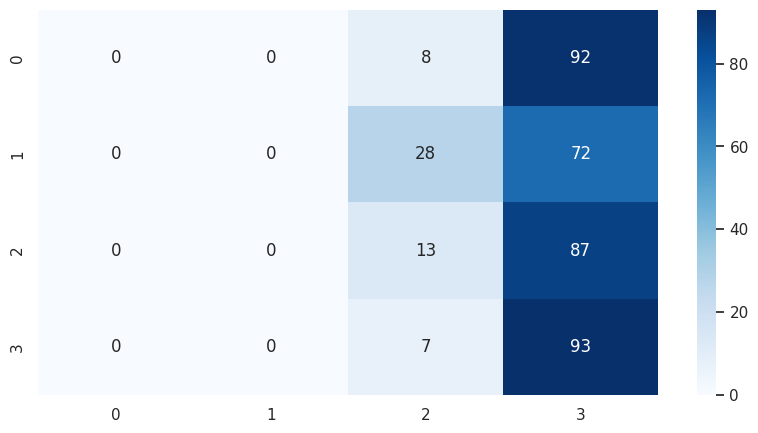

In [15]:
# check confusion matrix (with shares in every true class=rows)

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(
    cm / cm.sum(axis=1).reshape(-1, 1) * 100, 
    annot=True,
    # fmt='g',
    cmap='Blues',
)

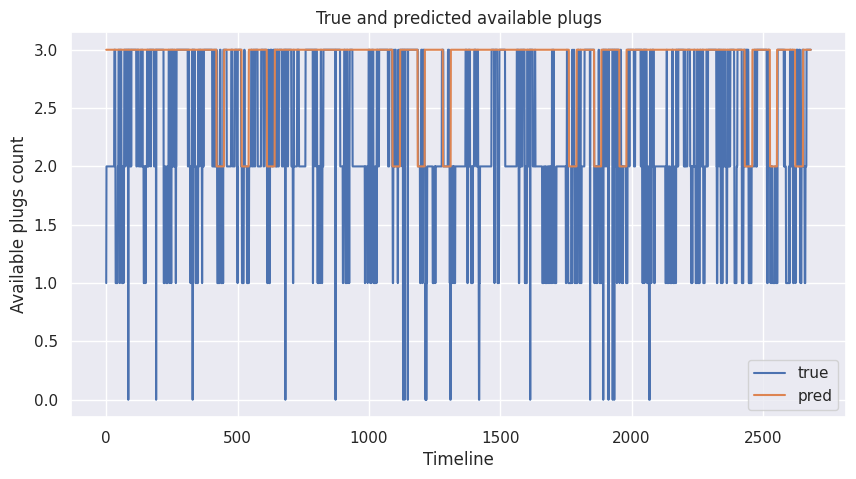

In [16]:
# check comparison of true and predicted available plugs

df_results = pd.DataFrame({
    "true": y_test.values,
    "pred": y_test_pred,
})

# ax = df_results.plot(alpha=0.75)
ax = df_results.plot()

ax.set_xlabel("Timeline")
ax.set_ylabel("Available plugs count")
ax.set_title("True and predicted available plugs")

plt.show()

## Results

- Created a base model on the data of the most frequent station only!
- The results are following:
    - accuracy: 0.452
    - precision: 0.381
    - recall: 0.452
    - F1: 0.347
    - accuracy (top k=2): 0.846